#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 16
**CH16A Predicting apartment prices with random forest**

using the airbnb dataset

version 0.92 2021-07-05

In [54]:
import os
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mizani.formatters import percent_format
from patsy import dmatrices
from plotnine import *
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import (
    partial_dependence,
    permutation_importance
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


## PART I
### Loading and preparing data 
----------------------------------------------

In [55]:
# !!! make sure you have run ch16-airbnb-prepare-london.ipynb before
area = "london"
data = pd.read_csv("/workspaces/codespaces-jupyter/notebooks/airbnb_london_workfile_adj.csv")
data = data.loc[data.price.notna(), :]


In [56]:
def count_missing_values(df):
    return df.isna().sum()[df.isna().sum() > 0]

In [57]:
count_missing_values(data)

Series([], dtype: int64)

In [58]:
# OR 

data.isna().any().any()

np.False_

In [59]:
# Sample definition and preparation ---------------------------------------

# We focus on normal apartments, n<8
data = data.loc[lambda x: x["n_accommodates"] < 8]


In [60]:
# copy a variable - purpose later, see at variable importance
data = data.assign(n_accommodates_copy=data.n_accommodates)

In [61]:
# basic descr stat -------------------------------------------
data.describe()

,usd_price_day,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,n_minimum_nights,n_beds,...,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,n_accommodates_copy
count,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.00000,49826.000000,49826.000000,...,49826.000000,49826.000000,49826.0,49826.000000,49826.000000,49826.000000,4.982600e+04,4.982600e+04,49826.000000,49826.000000
mean,88.984044,2.838759,1.224260,92.458616,12.340144,1.356180,1.138253,6.50873,3.300947,1.585959,...,0.318850,0.303998,0.0,5.713297,33.456371,199.607207,2.931985e+05,3.046539e+08,4.520910,2.838759
std,70.515089,1.494748,0.466448,8.418474,25.889935,0.879263,1.238156,12.31549,29.578062,0.927501,...,0.466035,0.459986,0.0,0.902564,9.506988,80.264045,5.640361e+05,9.636140e+08,0.120421,1.494748
min,8.000000,1.000000,0.000000,20.000000,0.000000,1.000000,0.010000,0.00000,1.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.995732,1.000000
25%,41.000000,2.000000,1.000000,92.000000,0.000000,1.000000,0.470000,0.00000,1.000000,1.000000,...,0.000000,0.000000,0.0,5.433722,29.525335,160.432461,5.198400e+04,1.185235e+07,4.521789,2.000000
50%,70.000000,2.000000,1.000000,94.000000,3.000000,1.000000,0.770000,0.00000,2.000000,1.000000,...,0.000000,0.000000,0.0,5.793014,33.559007,194.407782,1.069290e+05,3.496578e+07,4.543295,2.000000
75%,110.000000,4.000000,1.000000,97.000000,12.000000,1.000000,1.170000,10.00000,3.000000,2.000000,...,1.000000,1.000000,0.0,6.224558,38.745128,241.171311,2.540160e+05,1.280241e+08,4.574711,4.000000
max,999.000000,7.000000,8.000000,100.000000,396.000000,16.000000,15.000000,240.00000,5000.000000,16.000000,...,1.000000,1.000000,0.0,7.909489,62.560024,494.817853,7.409284e+06,2.016807e+10,4.605170,7.000000


In [62]:
data.price.describe()

count    49826.000000
mean        88.984044
std         70.515089
min          8.000000
25%         41.000000
50%         70.000000
75%        110.000000
max        999.000000
Name: price, dtype: float64

In [63]:
data.f_room_type.value_counts()

f_room_type
Entire home/apt    24938
Private room       24351
Shared room          537
Name: count, dtype: int64

In [64]:
data.f_property_type.value_counts()

f_property_type
Apartment    37467
House        12359
Name: count, dtype: int64

In [65]:
data.f_number_of_reviews.value_counts()

f_number_of_reviews
[1.0, 51.0)      31575
[0.0, 1.0)       15147
[51.0, 396.0)     3103
1                    1
Name: count, dtype: int64

In [66]:
# create train and holdout samples -------------------------------------------
# train is where we do it all, incl CV

# First pick a smaller than usual training set so that models run faster and check if works
# If works, start anew without these two lines


In [67]:
data_train, data_holdout = train_test_split(data, train_size=0.7, random_state=42)

In [68]:
data_train.shape, data_holdout.shape

((34878, 92), (14948, 92))

In [69]:
# Basic Variables inc neighnourhood
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "f_cancellation_policy",
    "f_bed_type",
    "f_neighbourhood_cleansed",
]

# reviews
reviews = [
    "n_number_of_reviews",
    "flag_n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating",
]

# Dummy variables
amenities = [col for col in data if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
    "f_room_type:d_familykidfriendly",
    "d_airconditioning:f_property_type",
    "d_cats:f_property_type",
    "d_dogs:f_property_type",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]


In [70]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2

## PART II
### RANDOM FORESTS 
-------------------------------------------------------

**Note:** n_estimators=500 in the R code.

Here, we set it to 30 because the model runs mutch faster, and this does not change the results substantively here – however in other cases might.

In [71]:
# NOTE: set number of cores you want to run models
ncores = 7

In [72]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=30, #here yes
    oob_score=True,
    n_jobs=ncores,
)

tune_grid = {"max_features": [5, 7, 9], 
             "min_samples_split": [6, 11]}

rf_random = GridSearchCV(
    rfr, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=3
)

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

rf_model_1 = rf_random.fit(X, y.ravel())


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END max_features=5, min_samples_split=6;, score=-45.984 total time=   0.4s
[CV 2/5] END max_features=5, min_samples_split=6;, score=-45.114 total time=   0.4s
[CV 3/5] END max_features=5, min_samples_split=6;, score=-46.043 total time=   0.4s
[CV 4/5] END max_features=5, min_samples_split=6;, score=-43.664 total time=   0.4s
[CV 5/5] END max_features=5, min_samples_split=6;, score=-46.533 total time=   0.4s
[CV 1/5] END max_features=5, min_samples_split=11;, score=-45.866 total time=   0.3s
[CV 2/5] END max_features=5, min_samples_split=11;, score=-45.493 total time=   0.3s
[CV 3/5] END max_features=5, min_samples_split=11;, score=-46.421 total time=   0.4s
[CV 4/5] END max_features=5, min_samples_split=11;, score=-43.752 total time=   0.3s
[CV 5/5] END max_features=5, min_samples_split=11;, score=-47.210 total time=   0.3s
[CV 1/5] END max_features=7, min_samples_split=6;, score=-45.572 total time=   0.4s
[CV 2/5] EN

In [74]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",  # It calculates the MSE before and after the split. If splitting reduces the total MSE, it’s a good split.
    n_estimators=30,         # Number of trees in the forest
    oob_score=True,          # Use out-of-bag samples to estimate test error
    n_jobs=ncores,           # Use multiple CPU cores (parallel processing)
)
tune_grid = {
    "max_features": [8, 10, 12],
    "min_samples_split": [6, 11, 16],
}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

rf_model_2 = rf_random.fit(X, y.ravel())


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=8, min_samples_split=6;, score=-45.475 total time=   0.5s
[CV 2/5] END max_features=8, min_samples_split=6;, score=-44.447 total time=   0.5s
[CV 3/5] END max_features=8, min_samples_split=6;, score=-44.723 total time=   0.5s
[CV 4/5] END max_features=8, min_samples_split=6;, score=-42.442 total time=   0.5s
[CV 5/5] END max_features=8, min_samples_split=6;, score=-45.982 total time=   0.4s
[CV 1/5] END max_features=8, min_samples_split=11;, score=-45.321 total time=   0.4s
[CV 2/5] END max_features=8, min_samples_split=11;, score=-44.445 total time=   0.4s
[CV 3/5] END max_features=8, min_samples_split=11;, score=-45.078 total time=   0.4s
[CV 4/5] END max_features=8, min_samples_split=11;, score=-43.297 total time=   0.4s
[CV 5/5] END max_features=8, min_samples_split=11;, score=-45.742 total time=   0.4s
[CV 1/5] END max_features=8, min_samples_split=16;, score=-45.299 total time=   0.4s
[CV 2/5] E

In [75]:
print(rf_model_2.cv_results_)

{'mean_fit_time': array([0.45460343, 0.37476954, 0.36025558, 0.4824317 , 0.43935065,
       0.40924387, 0.51982179, 0.48476801, 0.43622646]), 'std_fit_time': array([0.02191051, 0.00481794, 0.01469921, 0.03008167, 0.04135014,
       0.03290323, 0.01482531, 0.04610225, 0.01359905]), 'mean_score_time': array([0.02568283, 0.0252337 , 0.02518439, 0.02492962, 0.029076  ,
       0.02456851, 0.02693357, 0.02524443, 0.02471724]), 'std_score_time': array([0.0008252 , 0.00060867, 0.00126885, 0.00057159, 0.00917008,
       0.0003587 , 0.00065275, 0.00059333, 0.00046995]), 'param_max_features': masked_array(data=[8, 8, 8, 10, 10, 10, 12, 12, 12],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value=999999), 'param_min_samples_split': masked_array(data=[6, 11, 16, 6, 11, 16, 6, 11, 16],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value=999999), 'params': [{'max_fea

### Table 16.1 Random forest RMSE by tuning parameters

In [76]:
pd.DataFrame(rf_model_1.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"] - 1,
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    3
)

Variables,5,7,9
Min_nodes,,,
5,45.468,44.860,44.769
10,45.748,45.037,44.807


In [77]:
pd.DataFrame(rf_model_2.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"] - 1,
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    3
)


Variables,8,10,12
Min_nodes,,,
5,44.614,44.449,44.286
10,44.777,44.694,44.413
15,44.990,44.750,44.454


In [78]:
pd.DataFrame(
    {
        "Min vars": [
            rf_model_1.best_estimator_.max_features,
            rf_model_2.best_estimator_.max_features,
        ],
        "Min nodes": [
            rf_model_1.best_estimator_.min_samples_split - 1,
            rf_model_2.best_estimator_.min_samples_split - 1,
        ],
    },
    ["Model A", "Model B"],
)


,Min vars,Min nodes
Model A,9,5
Model B,12,5


In [79]:
# Confirm best parameters and their score:
print(rf_model_2.best_params_)
print(-rf_model_2.best_score_)

{'max_features': 12, 'min_samples_split': 6}
44.28620895799135


In [80]:
# Use .best_score_ instead of grabbing raw min from cv_results_
rf_model_1_rmse = -rf_model_1.best_score_  # Note: .best_score_ is already the highest (least negative)
rf_model_2_rmse = -rf_model_2.best_score_

pd.DataFrame(
    {"RMSE": [rf_model_1_rmse, rf_model_2_rmse]},
    index=["Model A", "Model B"]
).round(3)

,RMSE
Model A,44.769
Model B,44.286


In [81]:
rf_model_1_rmse = rf_model_1.cv_results_["mean_test_score"].min() * -1
rf_model_2_rmse = rf_model_2.cv_results_["mean_test_score"].min() * -1

pd.DataFrame(
    {"RMSE": [rf_model_1_rmse, rf_model_2_rmse]}, ["Model A", "Model B"]
).round(3)

,RMSE
Model A,45.748
Model B,44.990


## PART III
### MODEL DIAGNOSTICS 
---

In [ ]:
rf_model_2_var_imp_df = (
    pd.DataFrame(
        rf_model_2.best_estimator_.feature_importances_, X.design_info.column_names
    )
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(factor=lambda x: x["varname"].str.startswith("f_"))
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum(),
            varname=lambda x: x.varname.str.replace(
            "f_room_type[T.", "Room type:", regex=False
        )
        .str.replace("f_neighbourhood_cleansed[T.", "Borough:", regex=False)
        .str.replace("f_cancellation_policy[T.", "Cancelation policy:", regex=False)
        .str.replace("f_bed_type[T.", "Bed type:", regex=False)
        .str.replace("f_property_type[T.", "Property type:", regex=False)
        .str.replace("]", "", regex=False),
    )
    .sort_values(by=["imp"], ascending=False)
)

In [90]:
# Create a DataFrame of feature importances
rf_model_2_var_imp_df = pd.DataFrame({
    "varname": X.design_info.column_names,
    "imp": rf_model_2.best_estimator_.feature_importances_,
})

# Add new columns
rf_model_2_var_imp_df["factor"] = rf_model_2_var_imp_df["varname"].str.startswith("f_")
rf_model_2_var_imp_df["imp_percentage"] = (rf_model_2_var_imp_df["imp"] / rf_model_2_var_imp_df["imp"].sum()
)

# Clean up variable names for categorical dummies
rf_model_2_var_imp_df["varname"] = (
    rf_model_2_var_imp_df["varname"]
    .str.replace("f_room_type[T.", "Room type:", regex=False)
    .str.replace("f_neighbourhood_cleansed[T.", "Borough:", regex=False)
    .str.replace("f_cancellation_policy[T.", "Cancelation policy:", regex=False)
    .str.replace("f_bed_type[T.", "Bed type:", regex=False)
    .str.replace("f_property_type[T.", "Property type:", regex=False)
    .str.replace("]", "", regex=False)
)

# Sort by importance
rf_model_2_var_imp_df = rf_model_2_var_imp_df.sort_values(by="imp", ascending=False)

In [91]:
rf_model_2_var_imp_df

,varname,imp,factor,imp_percentage
2,Room type:Private room,0.154045,True,0.154045
42,n_accommodates,0.148558,False,0.148558
43,n_beds,0.095808,False,0.095808
6,"f_bathroom[T.[2, 10)",0.063184,True,0.063184
5,"f_bathroom[T.[1, 2)",0.041483,True,0.041483
...,...,...,...,...
81,d_paidparkingoffpremises,0.000099,False,0.000099
37,Borough:Sutton,0.000095,True,0.000095
66,d_freeparkingonstreet,0.000013,False,0.000013
0,Intercept,0.000000,False,0.000000


#### 1) full varimp plot, above a cutoff

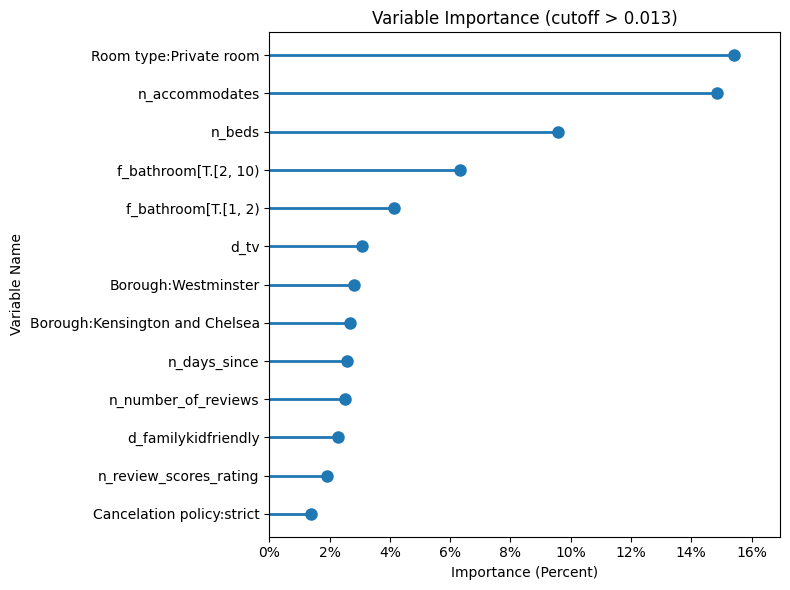

In [104]:
cutoff = 0.013
df_plot = rf_model_2_var_imp_df.loc[rf_model_2_var_imp_df.imp > cutoff].copy()
df_plot = df_plot.sort_values('imp_percentage', ascending=True)  # sort for clean vertical order

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Draw horizontal lines
ax.hlines(
    y=df_plot['varname'],
    xmin=0,
    xmax=df_plot['imp_percentage'],
    color='C0',
    linewidth=2
)

# Draw dots at the end
ax.plot(
    df_plot['imp_percentage'],
    df_plot['varname'],
    'o',
    color='C0',
    markersize=8
)

# Customize axes
ax.set_xlabel('Importance (Percent)')
ax.set_ylabel('Variable Name')
ax.set_title('Variable Importance (cutoff > 0.013)')
ax.set_xlim(0, df_plot['imp_percentage'].max() * 1.1)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

plt.tight_layout()
plt.show()

#### 2) full varimp plot, top 10 onl

In [105]:
rf_model_2_var_imp_df.iloc[:10, :]

,varname,imp,factor,imp_percentage
2,Room type:Private room,0.154045,True,0.154045
42,n_accommodates,0.148558,False,0.148558
43,n_beds,0.095808,False,0.095808
6,"f_bathroom[T.[2, 10)",0.063184,True,0.063184
5,"f_bathroom[T.[1, 2)",0.041483,True,0.041483
94,d_tv,0.030680,False,0.030680
41,Borough:Westminster,0.028012,True,0.028012
28,Borough:Kensington and Chelsea,0.026691,True,0.026691
44,n_days_since,0.025713,False,0.025713
45,n_number_of_reviews,0.025202,False,0.025202


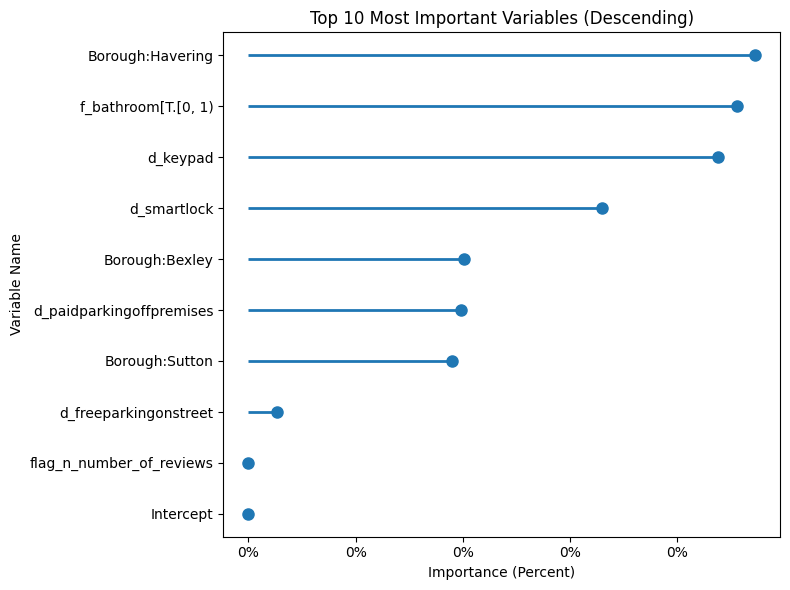

In [110]:
# Step 1: Sort descending and get top 10
top10 = rf_model_2_var_imp_df.sort_values('imp_percentage', ascending=True).head(10)

# Step 2: Create horizontal bar-style plot
fig, ax = plt.subplots(figsize=(8, 6))

# Horizontal lines
ax.hlines(y=top10['varname'], xmin=0, xmax=top10['imp_percentage'], color='C0', linewidth=2)

# Circle markers
ax.plot(top10['imp_percentage'], top10['varname'], 'o', color='C0', markersize=8)

# Labels and title
ax.set_xlabel('Importance (Percent)')
ax.set_ylabel('Variable Name')
ax.set_title('Top 10 Most Important Variables (Descending)')

# Format x-axis as percent
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

plt.tight_layout()
plt.show()

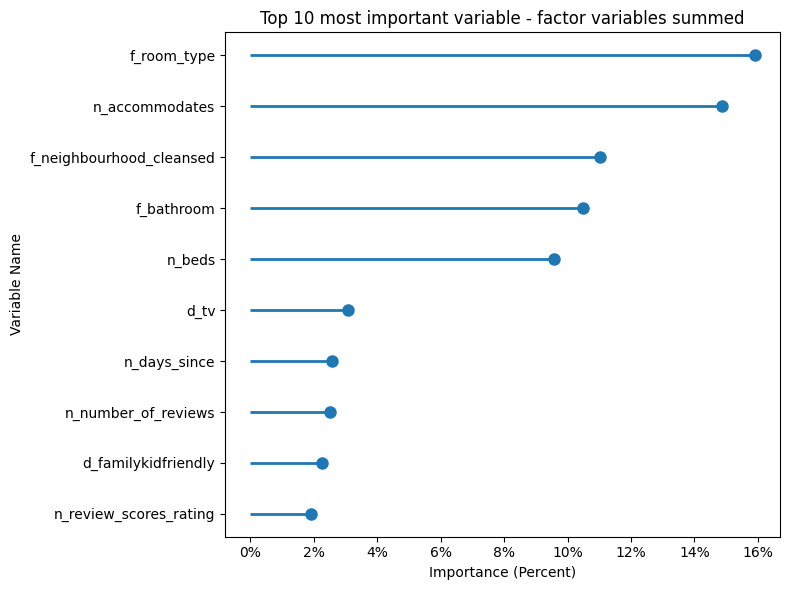

In [116]:


top10 = rf_model_2_var_imp_df_grouped.head(10).sort_values('imp_percentage', ascending=True)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hlines(y=top10['varname'], xmin=0, xmax=top10['imp_percentage'], color='C0', linewidth=2)
ax.plot(top10['imp_percentage'], top10['varname'], 'o', color='C0', markersize=8)
ax.set_xlabel('Importance (Percent)')
ax.set_ylabel('Variable Name')
ax.set_title('Top 10 most important variable - factor variables summed')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
plt.tight_layout()
plt.show()


#### 3) grouped variable importance - keep binaries created off factors together

First we do this by summing up the individual importances of factors - this is not correct, but it's in the first edition.

However, simply summing up the individual importances of each dummy could underestimate the importance of the qualitative variable. This occurs because omitting a single category might not significantly impact performance as the remaining correlated categories can still provide the model with the necessary information. To address this issue, we need to assess the impact of including the entire categorical variable, not just the individual dummies. We can create a pipeline which first encodes the categorical variables into dummy variables, then trains the model on the encoded data. Finally, we can employ a model-agnostic feature importance technique on this entire pipeline to estimate the contribution of each variable, including the qualitative variable as a whole.
 
Model-agnostic feature importance techniques are methods used to determine the importance of features in a model, regardless of the model type. These techniques work by assessing the impact of each feature on the model's predictions without relying on the internal workings of the model. One such technique is permutation feature importance, which randomly shuffles the values of variables and measures how much the fit of the prediction is decreased.

In [95]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

**Summing up individual importances of factors - first edition**

In [96]:
rf_model_2_var_imp_df_grouped = (
    pd.DataFrame(
        rf_model_2.best_estimator_.feature_importances_, X.design_info.column_names
    )
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(varname=lambda x: x["varname"].str.split("[").str[0])
    .sort_values(by=["imp"], ascending=False)
    .groupby("varname")[["imp"]]
    .sum()
    .reset_index()
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

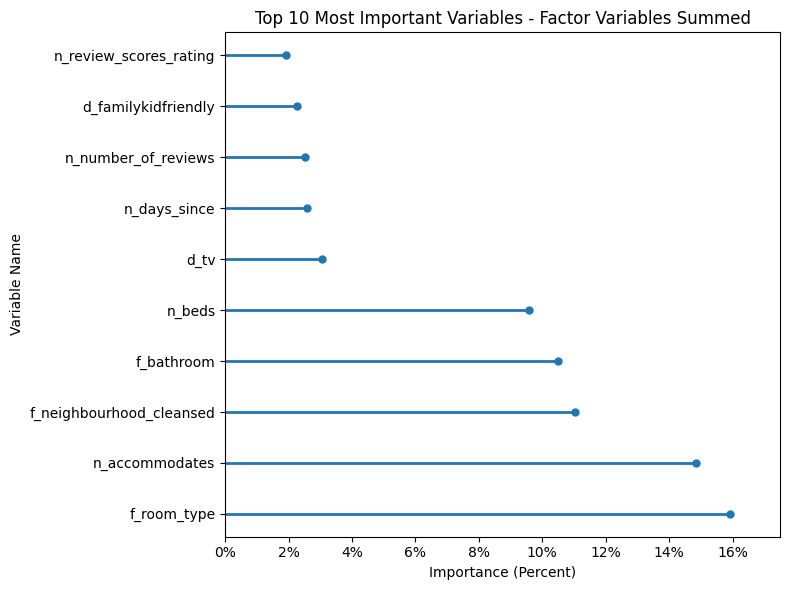

In [128]:
import matplotlib.pyplot as plt

# Ensure data is sorted properly
top10 = rf_model_2_var_imp_df_grouped.sort_values("imp_percentage", ascending=False).head(10)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot horizontal lines
ax.hlines(y=top10['varname'], xmin=0, xmax=top10['imp_percentage'], color='C0', linewidth=2)

# Plot the points
ax.plot(top10['imp_percentage'], top10['varname'], 'o', color='C0', markersize=5)

# Set axis labels and title
ax.set_xlabel('Importance (Percent)')
ax.set_ylabel('Variable Name')
ax.set_title('Top 10 Most Important Variables - Factor Variables Summed')

# Set percentage formatting correctly for x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

# Optional: expand x-axis limits a bit so you see all % clearly
ax.set_xlim(0, top10['imp_percentage'].max() * 1.1)

plt.tight_layout()
plt.show()

**OneHotEncoding and training the RandomForest model in a pipeline and calculating permutation importance - second edition**

In [129]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

rf_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", rf_model_2.best_estimator_),  # put best model to pipeline
    ]
)


In [137]:
rf_best_pipeline.fit(data_train[predictors_2], data_train.price)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathroom',
                                                   'f_cancellation_policy',
                                                   'f_bed_type',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_days_since',
                                                   'n_number_of_reviews',
                                                   'flag_n_number_of_reviews',
                                                   'n_review_scores_r...
                                                   'd_doormanentry', 'd_dryer',
                                                   'd_elevatorinbuilding',
                                                   'd_essentials',
                                                   'd_familykidfriendly',
                                                   'd_fireextinguisher',
                                                   'd_firstaidkit',
                                                   'd_freeparkingonpremises',
                                                   'd_freeparkingonstreet',
                                                   'd_gym', 'd_hairdryer',
                                                   'd_hangers', 'd_heating',
                                                   'd_hottub', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_split=6,
                                       n_estimators=30, n_jobs=7,
                                       oob_score=True, random_state=42))])

In [138]:
# This takes a while
result = permutation_importance(
    rf_best_pipeline,
    data_train[predictors_2],
    data_train.price,
    n_repeats=10,
    random_state=45,
    n_jobs=-1,
)


In [115]:
grouped_imp = (
    pd.DataFrame(result.importances_mean, data_train[predictors_2].columns)
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

In [ ]:
(
    ggplot(
        grouped_imp.head(10),
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + ggtitle("Top 10 most important variable calculated with permutation importance")
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

## Partial Dependence Plots 
-------------------------------------------------------


In [140]:
from sklearn.inspection import plot_partial_dependence

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (/home/codespace/.local/lib/python3.12/site-packages/sklearn/inspection/__init__.py)

In [139]:
# Note: easy way, sklearn has plot_partial_dependence function
# we do this on holdout set!
plot_partial_dependence(
    rf_best_pipeline,
    data_holdout[predictors_2],
    ["n_accommodates"],
    feature_names=data_holdout[predictors_2].columns,
    line_kw={"marker": "o", "color": color[0]},
)
plt.grid()
plt.ylim(70, 130)
plt.show()


NameError: name 'plot_partial_dependence' is not defined

In [ ]:
# replicate the exact book figure with plotnine
accom_pdp = partial_dependence(
    rf_best_pipeline, data_holdout[predictors_2], ["n_accommodates"], kind="average"
)

accom_pdp = (
    pd.DataFrame(accom_pdp["average"], columns=accom_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Accomodates (person)"}, axis=1)
)

(
    ggplot(accom_pdp, aes(x="Accomodates (person)", y="Predicted price"))
    + geom_point(color=color[0], size=2)
    + geom_line(color=color[0], size=1)
    + scale_y_continuous(limits=[70, 120], breaks=seq(70, 121, 10))
    + scale_x_continuous(breaks=range(1, 8))
    + theme_bw()
)


In [ ]:
roomtype_pdp = partial_dependence(
    rf_best_pipeline, data_holdout[predictors_2], ["f_room_type"], kind="average"
)

roomtype_pdp = (
    pd.DataFrame(roomtype_pdp["average"], columns=roomtype_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Room type"}, axis=1)
)

(
    ggplot(roomtype_pdp, aes(x="Room type", y="Predicted price"))
    + geom_point(color=color[0], size=2)
    + scale_y_continuous(limits=[60, 120], breaks=seq(60, 121, 10))
    + theme_bw()
)


### Subsample performance: RMSE / mean(y) 
---------------------------------------
NOTE  we do this on the holdout set.


In [ ]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf_best_pipeline.predict(data_holdout[predictors_2])
)


create nice summary table of heterogeneity

In [ ]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price)
        .round(2)
    )


In [ ]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)


In [ ]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_neighbourhood_cleansed.isin(
        [
            "Westminster",
            "Camden",
            "Kensington and Chelsea",
            "Tower Hamlets",
            "Hackney",
            "Newham",
        ]
    )
].groupby("f_neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)


In [ ]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_property_type.isin(["Apartment", "House"])
].groupby("f_property_type")
proptype_subset = calculate_rmse(grouped_object)


In [ ]:
all_holdout = (
    pd.DataFrame(
        [
            mean_squared_error(
                data_holdout_w_prediction.price,
                data_holdout_w_prediction.predicted_price,
                squared=False,
            ),
            data_holdout_w_prediction.price.mean(),
        ],
        index=["rmse", "mean_price"],
    )
    .T.assign(rmse_norm=lambda x: x.rmse / x.mean_price)
    .round(2)
)
all_holdout.index = ["All"]


In [ ]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type", "Borough"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("")


### Table 16.2 Performance across subsamples

In [ ]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        type_rows.iloc[[2]],
        neightbourhood_subset,
        all_holdout,
    ]
)


## PART IV
### HORSERACE: compare with other models 
-----------------------------------------------

1. OLS with dummies for area

 using model B

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [ ]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

ols_model = LinearRegression().fit(X, y)

# y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y, y_hat, squared=False)
ols_rmse


In [ ]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))


In [ ]:
ols_model_coeffs_df


2.  LASSO

using extended model w interactions

In [ ]:
from sklearn.linear_model import ElasticNet


The parameter l1_ratio corresponds to alpha in the glmnet R package while alpha corresponds to the lambda parameter in glmnet. Specifically, l1_ratio = 1 is the lasso penalty. Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [ ]:
lasso_model = ElasticNet(l1_ratio=1, normalize=True, fit_intercept=True)


In [ ]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(1, 26, 1)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


In [ ]:
y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)


In [ ]:
lasso_model_cv.fit(X, y.ravel())


In [ ]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]


In [ ]:
lasso_rmse = (
    pd.DataFrame(lasso_model_cv.cv_results_)
    .loc[lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha]
    .mean_test_score.values[0]
    * -1
)
lasso_rmse


3. CART model

In [ ]:
from sklearn.tree import DecisionTreeClassifier


In [ ]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)


In [ ]:
cart_model = DecisionTreeClassifier(random_state=2018, criterion="gini")


In [ ]:
# Get potential ccp_alpha parameters

path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities


In [ ]:
# apply random search to select a "best" alpha
# RandomizedSearchCV does not calculate all potential alphas, just a random subset

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha": ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


cart_model_cv.fit(X, y.ravel())


In [ ]:
cart_rmse = (
    pd.DataFrame(cart_model_cv.cv_results_)
    .loc[lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha]
    .mean_test_score.values[0]
    * -1
)
cart_rmse


4. GBM

**NOTE:** These models run for a **very long time** -- needs further investigations.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


In [ ]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20)

tune_grid = {"n_estimators": [i for i in range(200, 500, 50)], "max_depth": [1, 5, 10]}

gbm_model_cv = GridSearchCV(
    gbm, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=10, n_jobs=-1
)


In [ ]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)


In [ ]:
gbm_pipe.fit(data_train[predictors_2], data_train.price)


In [ ]:
gbm_rmse = gbm_pipe.steps[-1][1].best_score_ * -1

the next will be in final model, loads of tuning

In [ ]:
gbm_broad = GradientBoostingRegressor()


In [ ]:
tune_grid = {
    "n_estimators": [i for i in range(50, 500, 50)],
    "max_depth": [1, 5, 10],
    "learning_rate": [0.02, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": [5, 10, 20, 30],
}

gbm_model_cv_broad = GridSearchCV(
    gbm_broad,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
)


In [ ]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe_broad = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv_broad)], verbose=True
)


In [ ]:
gbm_pipe_broad.fit(data_train[predictors_2], data_train.price)


In [ ]:
gbm_broad_rmse = gbm_pipe_broad.steps[-1][1].best_score_ * -1

### Table 16.3 Predictive performance of different models

In [ ]:
pd.DataFrame(
    {
        "Model": [
            "Linear regression (OLS)",
            "Linear regression (LASSO)",
            "Regression Tree (CART)",
            "Random forest (basic tuning)",
            "Random forest (autotuned)",
            "GBM (basic tuning)",
            "GBM (broad tuning)",
        ],
        "RMSE": [
            ols_rmse,
            lasso_rmse,
            cart_rmse,
            rf_model_1_rmse,
            rf_model_2_rmse,
            gbm_rmse,
            gbm_broad_rmse,
        ],
    }
).round(1)